In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [66]:
df = pd.read_csv('data/Questionnaire to Benchmark Explainable AI Methods.csv')

In [67]:
df = df.drop('Timestamp', axis=1)
df.head(15)

,Is English your native language?,In which type of program are you currently enrolled?,What is your field of study related to?,In how many courses related to Artificial Intelligence did you participate?,Have you ever heard of 'Explainable AI' methods?,From the explanation I understand how the system makes a decision.,"The explanation is useful to me, for making better decisions or to perform an action.",The explanation increases my trust in the system.,The explanation provides sufficient information to explain how the system makes decisions.,I have a satisfied attitude towards the explanation of the system.,...,From the explanation I understand how the system makes a decision..2,"The explanation is useful to me, for making better decisions or to perform an action..2",The explanation increases my trust in the system..2,The explanation provides sufficient information to explain how the system makes decisions..2,I have a satisfied attitude towards the explanation of the system..2,From the explanation I understand how the system makes a decision..3,"The explanation is useful to me, for making better decisions or to perform an action..3",The explanation increases my trust in the system..3,The explanation provides sufficient information to explain how the system makes decisions..3,I have a satisfied attitude towards the explanation of the system..3
0,No,Bachelor,Other,0,No,2.0,5.0,2.0,4.0,1.0,...,2.0,3.0,1.0,1.0,1.0,1.0,4.0,2.0,4.0,5.0
1,Yes,Master,Data Science,Many,Yes,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,No,Bachelor,Psychology,1,No,6.0,5.0,4.0,5.0,5.0,...,5.0,5.0,4.0,5.0,4.0,6.0,6.0,5.0,6.0,6.0
3,No,Bachelor,Psychology,0,No,5.0,5.0,7.0,5.0,3.0,...,2.0,1.0,1.0,4.0,1.0,6.0,7.0,7.0,3.0,5.0
4,No,Master,Economics/Business,0,Yes,2.0,3.0,3.0,3.0,3.0,...,4.0,5.0,4.0,6.0,4.0,4.0,7.0,6.0,5.0,6.0
5,No,NaN,Engineering,0,No,6.0,5.0,7.0,7.0,6.0,...,1.0,1.0,1.0,1.0,1.0,7.0,7.0,7.0,7.0,7.0
6,No,Graduate,Humanities,0,No,6.0,6.0,6.0,6.0,6.0,...,6.0,2.0,5.0,3.0,2.0,6.0,7.0,7.0,NaN,7.0
7,No,Other,Natural Sciences,0,No,5.0,6.0,4.0,5.0,NaN,...,2.0,1.0,2.0,1.0,1.0,6.0,7.0,6.0,7.0,6.0
8,No,Other,Natural Sciences,0,No,4.0,5.0,5.0,3.0,5.0,...,6.0,5.0,6.0,5.0,6.0,4.0,4.0,3.0,3.0,4.0
9,No,Master,Law,0,No,6.0,6.0,4.0,6.0,5.0,...,1.0,1.0,3.0,1.0,1.0,6.0,6.0,5.0,6.0,6.0


In [68]:
original_column_names = df.columns
original_column_names.shape

(25,)

In [69]:
new_columns = [f'question {i}' for i in range(1,26)]
df.columns = new_columns

In [70]:
ml_background = df[df['question 3'] == 'AI']
ml_background = ml_background.append(df[df['question 3'] == 'Data Science'])

In [71]:
non_ml_background = df.drop(index=ml_background.index)

,question 1,question 2,question 3,question 4,question 5,question 6,question 7,question 8,question 9,question 10,...,question 16,question 17,question 18,question 19,question 20,question 21,question 22,question 23,question 24,question 25
0,No,Bachelor,Other,0,No,2.0,5.0,2.0,4.0,1.0,...,2.0,3.0,1.0,1.0,1.0,1.0,4.0,2.0,4.0,5.0
2,No,Bachelor,Psychology,1,No,6.0,5.0,4.0,5.0,5.0,...,5.0,5.0,4.0,5.0,4.0,6.0,6.0,5.0,6.0,6.0
3,No,Bachelor,Psychology,0,No,5.0,5.0,7.0,5.0,3.0,...,2.0,1.0,1.0,4.0,1.0,6.0,7.0,7.0,3.0,5.0
4,No,Master,Economics/Business,0,Yes,2.0,3.0,3.0,3.0,3.0,...,4.0,5.0,4.0,6.0,4.0,4.0,7.0,6.0,5.0,6.0
5,No,NaN,Engineering,0,No,6.0,5.0,7.0,7.0,6.0,...,1.0,1.0,1.0,1.0,1.0,7.0,7.0,7.0,7.0,7.0
6,No,Graduate,Humanities,0,No,6.0,6.0,6.0,6.0,6.0,...,6.0,2.0,5.0,3.0,2.0,6.0,7.0,7.0,NaN,7.0
7,No,Other,Natural Sciences,0,No,5.0,6.0,4.0,5.0,NaN,...,2.0,1.0,2.0,1.0,1.0,6.0,7.0,6.0,7.0,6.0
8,No,Other,Natural Sciences,0,No,4.0,5.0,5.0,3.0,5.0,...,6.0,5.0,6.0,5.0,6.0,4.0,4.0,3.0,3.0,4.0
9,No,Master,Law,0,No,6.0,6.0,4.0,6.0,5.0,...,1.0,1.0,3.0,1.0,1.0,6.0,6.0,5.0,6.0,6.0
10,No,Bachelor,Engineering,0,No,4.0,3.0,4.0,2.0,3.0,...,7.0,6.0,7.0,6.0,7.0,7.0,7.0,7.0,7.0,7.0


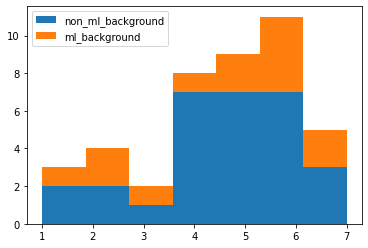

In [142]:
data = [non_ml_background['question 6'], ml_background['question 6']]
data
plt.hist(data, bins=7, histtype='barstacked',  label=['non_ml_background', 'ml_background'])
plt.legend()

use the


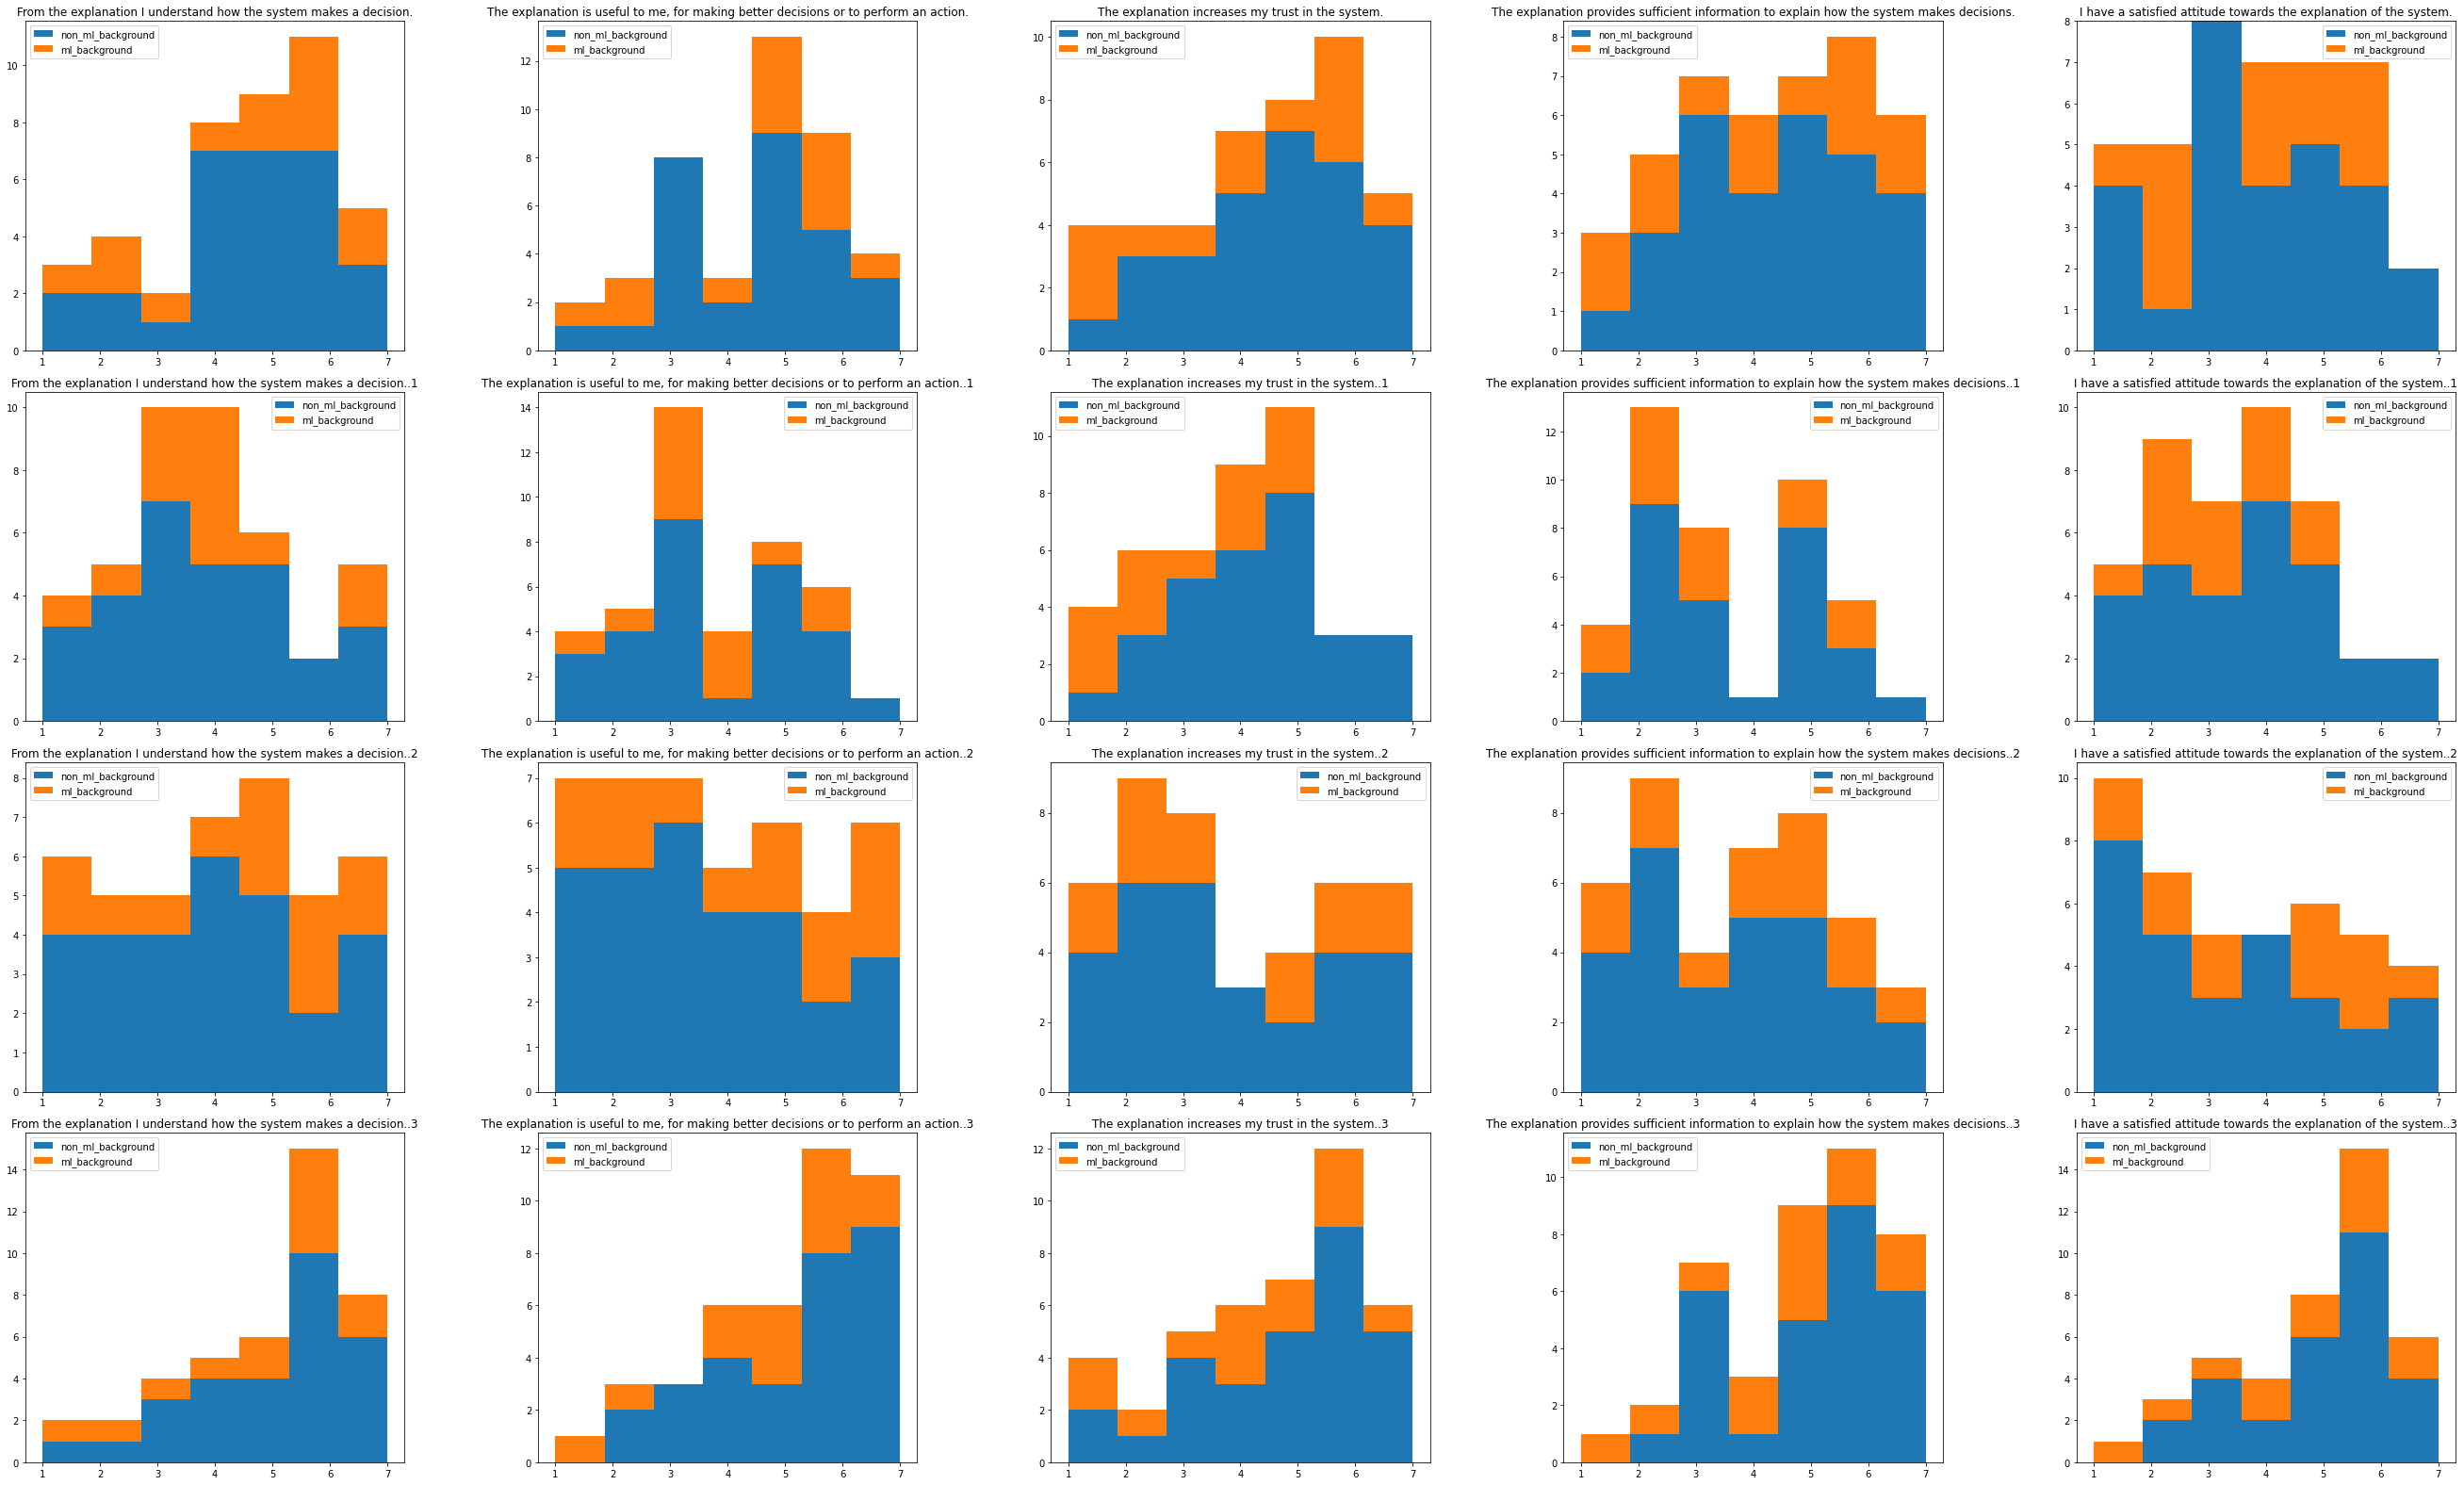

In [157]:
def get_histo_grid(safe_fig=False):
    fig, axs = plt.subplots(4,5)
    fig.set_size_inches(37, 22)
    # fig.subplots_adjust(hspace=1.0, wspace=1.0)
    for i in range(6,26):
        data = [non_ml_background[f'question {i}'], ml_background[f'question {i}']]
        row = (i-6)//5
        col = (i-6)%5
        # axs[row,col].set_size_inches(18.5, 10.5)
        axs[row,col].hist(data, bins=7, histtype='barstacked',  label=['non_ml_background', 'ml_background'])
        axs[row,col].set_title(original_column_names[i-1])
        axs[row,col].legend()
    # plt.legend()
    plt.tight_layout()
    if safe_fig:
        plt.savefig('histo_grid')

get_histo_grid(safe_fig=True)